In [26]:
from IPython.display import Markdown, display
from IPython.utils import io
import matplotlib.pyplot as plt
import numpy as np

# Helper functions
def printm( str ):
    display(Markdown(str))

    
def get_graph( i ):
    if i == 0:
        return "Follow"
    if i == 1:
        return "Quote"
    if i == 2:
        return "Reply"
    if i == 3:
        return "Retweet"

def change_coef_name(coefs_names):
    for n,i in enumerate(coefs_names):
        if i.startswith('ct'): # edit pairwise triad names, prev form pX-AB, new P_X(A,B)
            temp = 'P_{'+i[2]+'}'+'('+i[4]+','+i[5:]+')'
            print(temp)
            coefs_names[n] = '${}$'.format(temp)
        elif i.startswith('t'):
            temp = 'T_{'+i[1]+'}'+'('+i[3:]+')'
            coefs_names[n] = '${}$'.format(temp)
        elif i.startswith('d'):
            if i[-1] == 't' and i[-2] != 'r':
                if i[2:4] == 'ou':
                    node = 'u'
                else:
                    node = 'v'
                temp = 'Total('+node+')'
            else:
                if i[2:4] == 'ou':
                    node = 'Out'
                else:
                    node = 'In'
                if i[-2:] == 'rt':
                    inter = 'rt'
                else:
                    inter = i[-1]
                temp = node+'('+inter+')'
            coefs_names[n] = '${}$'.format(temp)
    return coefs_names

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

# Init results arrays   
results = [None for i in range(4)]
one_hand_another = np.zeros((4,4))
coefs_weights  = [None for i in range(4)]
coefs_names = [[] for _ in range(4)] 

# Read result files
with open("results/prediction_task.txt") as f:
    printm("# Summary of results")
    f.readline()
    for i in range(4):
            results[i] = {}
            coefs_weights[i] = {}
            samples = f.readline().split()[-2]
            printm("## {} Graph ".format(get_graph(i)))
            printm("Balanced dataset using: {:,} data".format(int(samples)))
            # Results for graph i for different features
            printm("### 1. Predict whether an edge belongs to {} graph using features from all graphs".format(get_graph(i)))
            for j in range(5):
                X = f.readline().split()
                results[i][X[0]] = [X[3],X[6]]
            for predictor, values in results[i].items():
                printm("**{}**:\t{} ($\pm${})".format(predictor, values[0][:-1], values[1]))
            f_names = f.readline().split('\t')
            f_names[len(f_names)-1] = f_names[len(f_names)-1][:-2]
            f_scores = f.readline().split('\t')
            f_scores[len(f_scores)-1] = f_scores[len(f_scores)-1][:-2]
            f_scores = [float(s) for s in f_scores]
            zipped = zip(f_names, f_scores)
            coefs_names[i] = {}
            with io.capture_output() as captured:
                change_coef_name(f_names)
            coefs_names[i]['X_all'] = f_names
            coefs_weights[i]['X_all'] = f_scores
            zipped = sorted(zipped, key = lambda t: t[1], reverse=True)
            printm(" - **5 highest logistic regression coefficients**")
            for j in range(5):
                if j == 5:
                    print("\n")
                print("{} : {:.2f}\t".format(zipped[j][0], zipped[j][1]),end='')
            printm(" - **5 lowest logistic regression coefficients**")
            for j in range(1,6):
                if j == 6:
                    print("\n")
                print("{} : {:.2f}\t".format(zipped[len(zipped)-j][0], zipped[len(zipped)-j][1]),end='')
            printm("### 2. Predict whether an edge belongs to {} graph using features only from this graphs".format(get_graph(i)))
            X = f.readline().split()
            results[i][X[0]] = [X[3],X[6]]
            printm("**{}**:\t{} ($\pm${})".format(X[0], X[3][:-1], X[6]))
            printm("### 3. Predict {} type using one additional type".format(get_graph(i)))
            for j in range(4):
                f.readline()
                X = f.readline().split()
                one_hand_another[i][j] = float(X[2][:-1])
                printm("{} with {}: {}".format(get_graph(i), get_graph(j), X[2]))

# Summary of results

## Follow Graph 

Balanced dataset using: 1,082,997 data

### 1. Predict whether an edge belongs to Follow graph using features from all graphs

**X_all**:	0.797 ($\pm$0.001)

**X_deg**:	0.784 ($\pm$0.001)

**X_triads**:	0.725 ($\pm$0.001)

**X_composite**:	0.727 ($\pm$0.001)

**X_triads_composite**:	0.734 ($\pm$0.001)

 - **5 highest logistic regression coefficients**

$In(f)$ : 1.69	$Out(f)$ : 0.99	$Total(v)$ : 0.62	$T_{5}(f)$ : 0.60	$Total(u)$ : 0.56	

 - **5 lowest logistic regression coefficients**

$In(rt)$ : -0.86	$Out(rt)$ : -0.73	$P_{8}(q,rt)$ : -0.43	$T_{5}(rt)$ : -0.34	$T_{8}(rt)$ : -0.31	

### 2. Predict whether an edge belongs to Follow graph using features only from this graphs

**X_only_i**:	0.736 ($\pm$0.001)

### 3. Predict Follow type using one additional type

Follow with Follow: 0.736,

Follow with Quote: 0.747,

Follow with Reply: 0.745,

Follow with Retweet: 0.762,

## Quote Graph 

Balanced dataset using: 666,820 data

### 1. Predict whether an edge belongs to Quote graph using features from all graphs

**X_all**:	0.715 ($\pm$0.001)

**X_deg**:	0.694 ($\pm$0.001)

**X_triads**:	0.629 ($\pm$0.001)

**X_composite**:	0.671 ($\pm$0.001)

**X_triads_composite**:	0.685 ($\pm$0.001)

 - **5 highest logistic regression coefficients**

$P_{8}(q,rt)$ : 1.96	$Out(q)$ : 0.98	$In(q)$ : 0.73	$T_{3}(q)$ : 0.68	$P_{5}(q,rt)$ : 0.27	

 - **5 lowest logistic regression coefficients**

$Out(rt)$ : -0.48	$P_{8}(f,rt)$ : -0.46	$In(r)$ : -0.36	$Out(f)$ : -0.35	$In(rt)$ : -0.35	

### 2. Predict whether an edge belongs to Quote graph using features only from this graphs

**X_only_i**:	0.626 ($\pm$0.001)

### 3. Predict Quote type using one additional type

Quote with Follow: 0.675,

Quote with Quote: 0.626,

Quote with Reply: 0.651,

Quote with Retweet: 0.692,

## Reply Graph 

Balanced dataset using: 1,259,970 data

### 1. Predict whether an edge belongs to Reply graph using features from all graphs

**X_all**:	0.769 ($\pm$0.001)

**X_deg**:	0.756 ($\pm$0.001)

**X_triads**:	0.655 ($\pm$0.001)

**X_composite**:	0.672 ($\pm$0.001)

**X_triads_composite**:	0.671 ($\pm$0.001)

 - **5 highest logistic regression coefficients**

$Out(r)$ : 3.04	$In(r)$ : 0.50	$P_{6}(r,rt)$ : 0.37	$T_{9}(r)$ : 0.31	$In(f)$ : 0.26	

 - **5 lowest logistic regression coefficients**

$Out(rt)$ : -2.67	$In(rt)$ : -0.73	$Total(u)$ : -0.71	$P_{3}(r,rt)$ : -0.30	$In(q)$ : -0.27	

### 2. Predict whether an edge belongs to Reply graph using features only from this graphs

**X_only_i**:	0.581 ($\pm$0.000)

### 3. Predict Reply type using one additional type

Reply with Follow: 0.685,

Reply with Quote: 0.633,

Reply with Reply: 0.581,

Reply with Retweet: 0.755,

## Retweet Graph 

Balanced dataset using: 1,499,593 data

### 1. Predict whether an edge belongs to Retweet graph using features from all graphs

**X_all**:	0.771 ($\pm$0.001)

**X_deg**:	0.743 ($\pm$0.000)

**X_triads**:	0.674 ($\pm$0.000)

**X_composite**:	0.666 ($\pm$0.000)

**X_triads_composite**:	0.682 ($\pm$0.000)

 - **5 highest logistic regression coefficients**

$Out(rt)$ : 2.36	$Total(u)$ : 0.80	$In(rt)$ : 0.66	$T_{3}(rt)$ : 0.59	$T_{5}(rt)$ : 0.45	

 - **5 lowest logistic regression coefficients**

$Out(r)$ : -1.29	$P_{8}(q,rt)$ : -1.02	$Out(q)$ : -0.58	$P_{7}(r,rt)$ : -0.38	$P_{6}(r,rt)$ : -0.35	

### 2. Predict whether an edge belongs to Retweet graph using features only from this graphs

**X_only_i**:	0.682 ($\pm$0.001)

### 3. Predict Retweet type using one additional type

Retweet with Follow: 0.710,

Retweet with Quote: 0.726,

Retweet with Reply: 0.722,

Retweet with Retweet: 0.682,

In [39]:
printm("# One versus all layers")
import pandas as pd
from statistics import mean, stdev
data = np.zeros((4,3))
for i in range(4):
    all_layers = float(results[i]['X_all'][0][:-1])
    one_layer = float(results[i]['X_only_i'][0][:-1])
    data[i][0] = all_layers
    data[i][1] = one_layer
    data[i][2] = (((all_layers-one_layer)/one_layer)*100)
data[:,2] = data[:,2].round(decimals=2)
index = [get_graph(i) for i in range(4)]
columns = ['All layers', 'One layer', 'Relative improvement (%)']
pd.DataFrame(data, index=index, columns=columns)

# One versus all layers

,All layers,One layer,Relative improvement (%)
Follow,0.797,0.736,8.29
Quote,0.715,0.626,14.22
Reply,0.769,0.581,32.36
Retweet,0.771,0.682,13.05


# One hand helping the other

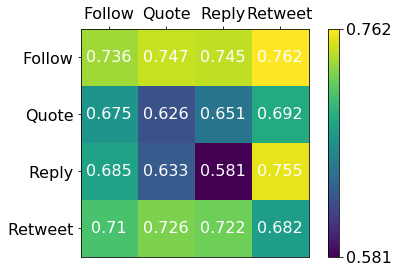

In [28]:
printm("# One hand helping the other")
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

graph_types = ["Follow", "Quote", "Reply", "Retweet"]

fig, ax = plt.subplots()
im = ax.imshow(one_hand_another)

# We want to show all ticks...
ax.set_xticks(np.arange(len(graph_types)))
ax.set_yticks(np.arange(len(graph_types)))
# ... and label them with the respective list entries
ax.set_xticklabels(graph_types)
ax.set_yticklabels(graph_types)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.xaxis.tick_top()
# Loop over data dimensions and create text annotations.
for i in range(len(graph_types)):
    for j in range(len(graph_types)):
        text = ax.text(j, i, one_hand_another[i, j],
                       ha="center", va="center", color="w")
fig.tight_layout()
cbar = fig.colorbar(im, ticks=[np.amin(one_hand_another), np.amax(one_hand_another)])
plt.show()

# Bar chart of predictions

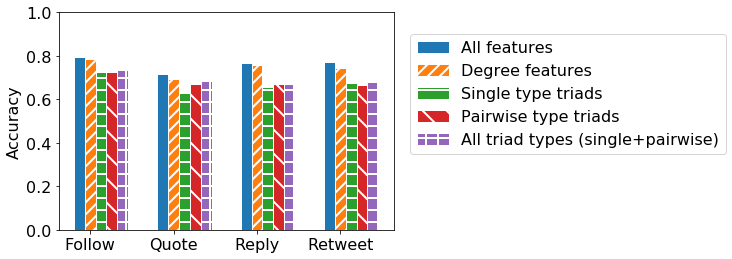

In [19]:
printm("# Bar chart of predictions")

# libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

plt.rcParams['hatch.linewidth'] = 2.0 

graph_names = [get_graph(i) for i in range(4)]
feature_sets = list(results[0].keys())
 
# set width of bar
barWidth = 0.13
 
# set height of bar
bars =[[]*4 for i in range(5)]
for i in range(5):
    for j in range(4):
        bars[i].append(float(results[j][feature_sets[i]][0][:-1]))

feature_sets = ['All features', 'Degree features', 'Single type triads', 'Pairwise type triads', 'All triad types (single+pairwise)', 'Features only from this graph', 'Features from all others, but this graph']
# Set position of bar on X axis
r = [[t+barWidth*i for t in np.arange(len(bars[0]))]for i in range(len(feature_sets))]
hatches = ['', '//', '-', '\\','+', 'x', '*']
# Make the plot
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    plt.bar(r[i], bars[i], color=colors[i], width=barWidth, hatch=hatches[i], edgecolor='white', label=feature_sets[i])
 
# Add xticks on the middle of the group bars
#plt.title('Prediction accuracy using all data', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[0]))], graph_names)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.05, 0.9), loc=2, borderaxespad=0.)

plt.show()

# Logistic regression coefficients

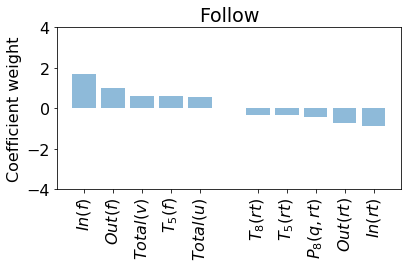

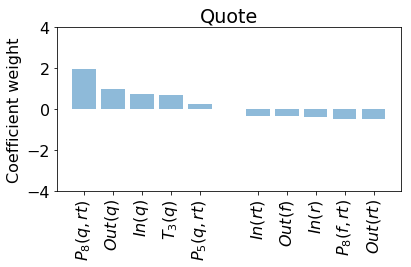

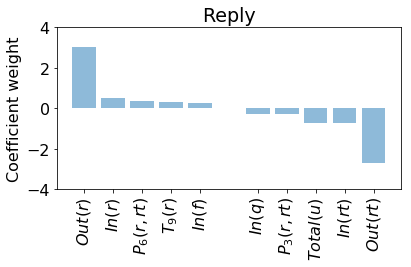

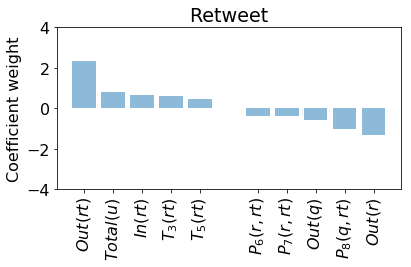

In [22]:
printm("# Logistic regression coefficients")
for gt in range(4):
    # ALL FEATURES
    coefs_weights
    top5 = np.flip(np.argsort(coefs_weights[gt]['X_all'])[-5:],axis=0)
    bottom5 = np.flip(np.argsort(coefs_weights[gt]['X_all'])[:5],axis=0)
    best_coefs = np.concatenate((top5, bottom5), axis=None)
    
    names = [coefs_names[gt]['X_all'][i] for i in best_coefs]
    x_pos = [i if i<=4 else i+1 for i in np.arange(len(best_coefs))]
    CTEs = [coefs_weights[gt]['X_all'][i] for i in best_coefs]
    
    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, CTEs, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Coefficient weight')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(names, rotation='vertical')
    plt.ylim(-4,4)
    # show the figure
    plt.title("{}".format(get_graph(gt)))
    plt.tight_layout()
    plt.show()

# Average accuracy be edge embeddedness

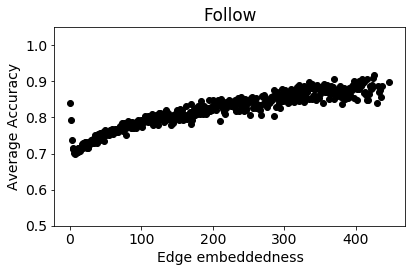

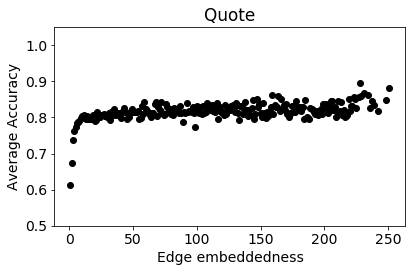

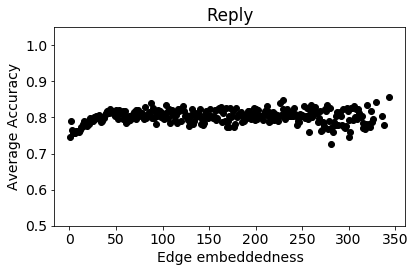

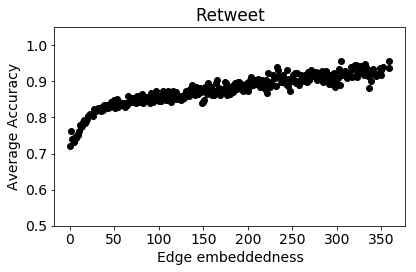

In [48]:
printm("# Average accuracy be edge embeddedness")
import pickle as pickle

with open('results/embAll_1_28.pk', 'rb') as f:
    embAll = pickle.load(f)
    
for i in range(4):
    x = list(embAll[i].keys())
    z = list(embAll[i].values())
    
    # remove those that appear less than 20 times
    toRemove = []
    for j in range(len(z)):
        if len(z[j]) < 500:
            toRemove.append(j)
    
    x = [x[t]+1 for t in range(len(x)) if t not in toRemove ]
    z = [z[t] for t in range(len(z)) if t not in toRemove ]
    
    # Find accuracy and plot scatter-plot
    y = [0 for _ in range(len(z))]
    for j in range(len(z)):
        y[j] = z[j].count(True)/len(z[j])
    #min_index = y.index(min(y))
    #print("Minimum value for {} is: {}".format(get_graph(i), min_index)) 
    a = plt.rcParams.update({'font.size': 14})
    a = plt.scatter(x,y, color='black')
    #a = plt.plot([min_index], [y[min_index]], marker='o', markersize=20, color="red")
    a = plt.title("{}".format(get_graph(i)))
    a = plt.xlabel("Edge embeddedness")
    a = plt.ylabel("Average Accuracy")
    a = plt.ylim(0.5, 1.05)
    a = plt.tight_layout()
    plt.show()